In [88]:
import numpy as np
import pickle
import scipy
import h5py
import scipy.io as sio
from pyriemann.utils.mean import mean_covariance
import sklearn.datasets
import sklearn.decomposition
from scipy.spatial import distance
import sys
import os
from scipy import linalg

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [92]:
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

def enablePrint():
    sys.stdout = sys.__stdout__


np.seterr(divide='ignore', invalid='ignore')


def get_data(parc, twin='DZ'):
    '''
    Navigates through file tree and extracts test/retest FCs 
    '''
    master_dir = '../data/twins'
    tasks = ['rest', 'emotion', 'gambling', 'language', 'motor', 'relational', 'social', 'wm']
    FC, test, retest = {}, {}, {}
    for task in tasks:
        task_dir = master_dir + f'/{task.upper()}/origmat_{twin}_schaefer{parc}_tests.mat'
        f = h5py.File(task_dir, 'r')
        for k, v in f.items():
            test[task] = np.array(v)
        task_dir = master_dir + f'/{task.upper()}/origmat_{twin}_schaefer{parc}_retests.mat'
        f = h5py.File(task_dir, 'r')
        for k, v in f.items():
            retest[task] = np.array(v)
        FC[task] = np.concatenate((test[task], retest[task])) 
    return FC

def utri2mat(utri):
    '''
    Converts upper triangular back to matrix form and fills in main diagonal with 1s
    '''
    n = int(-1 + np.sqrt(1 + 8 * len(utri))) // 2
    iu1 = np.triu_indices(n+1,1)
    ret = np.empty((n+1, n+1))
    ret[iu1] = utri
    ret.T[iu1] = utri
    np.fill_diagonal(ret, 1)
    return ret

def q1invm(q1, eig_thresh=0):
    q1 += np.eye(q1.shape[0])
    U, S, V = scipy.linalg.svd(q1)
    S = np.diag(S ** (-1 / 2))
    Q1_inv_sqrt = U @ S @ V
    Q1_inv_sqrt = (Q1_inv_sqrt + np.transpose(Q1_inv_sqrt)) / 2
    return Q1_inv_sqrt


def tangential(all_FC, ref):
    # Regularization for riemann
    if ref in ['riemann', 'kullback_sym', 'logeuclid']:
        print("Adding regularization!")
        eye_mat = np.eye(all_FC.shape[1])
        scaling_mat = np.repeat(eye_mat[None, ...], all_FC.shape[0], axis=0)
        all_FC += scaling_mat
    Cg = mean_covariance(all_FC, metric=ref)
    Q1_inv_sqrt = q1invm(Cg)
    Q = Q1_inv_sqrt @ all_FC @ Q1_inv_sqrt
    tangent_FC = np.empty(Q.shape)
    for idx, fc in enumerate(Q):
        if idx % 100 == 0:
            print(f'{idx}/{Q.shape[0]}')
        blockPrint()
        tangent_FC[idx] = linalg.logm(fc)
        enablePrint()
    return tangent_FC

## Data and Labels

In [93]:
# Get data
twin = 'MZ'
FCs = get_data(100, twin=twin)
nFCs = FCs['rest'].shape[0]

In [94]:
FCs['rest']
parc = 100
FC = np.zeros((FCs['rest'].shape[0], parc+14, parc+14))
for idx, utri in enumerate(FCs['rest']):
    FC[idx] = utri2mat(utri)
    
tan_fcs = tangential(FC, 'euclid')

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


([], <a list of 0 Text yticklabel objects>)

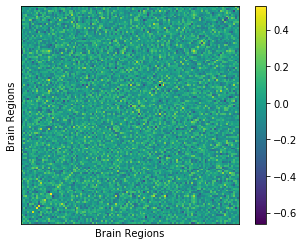

In [95]:
import matplotlib.pyplot as plt
plt.imshow(tan_fcs[0],origin='lower')
plt.ylabel('Brain Regions')
plt.xlabel('Brain Regions')
plt.colorbar()
if ref == 'euclid':
    plt.clim(-1,1)
plt.xticks([], [])
plt.yticks([],[])

In [47]:
# Get train and test labels
labels = np.tile(np.repeat(np.arange(0,FCs['rest'].shape[0]/4),2),2)
labels = labels.astype(int)
train_idx = np.arange(0,FCs['rest'].shape[0],2)
train_idx = train_idx.astype(int)
test_idx = np.arange(1, int(FCs['rest'].shape[0]), 2)
test_idx = test_idx.astype(int)
train_labels = labels[train_idx]
test_labels = labels[test_idx]

### KNN Approach - Manual Tangent Space, all Parcellations, all Tasks

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
accuracies = {}
lengths = {100:6441, 200:22791, 300:49141, 400:85491, 500:131841}
for ref in ['logeuclid', 'harmonic', 'kullback_sym', 'logeuclid', 'riemann']:
    print(f"Using {ref} transformation\n")
    for parc in np.arange(100, 600, 100):
        FCs = get_data(parc, twin=twin)
        for task in ['rest', 'emotion', 'gambling', 'language', 'motor', 'relational', 'social', 'wm']:
            if ref != 'original':
                with open(f'../data/tangent_fcs/twins/{task}/{twin}_{parc}_{ref}.pickle', 'rb') as f:
                    task_FCs = pickle.load(f)
                vec_FCs = np.zeros((nFCs, lengths[parc]), dtype=np.float32)
                for idx, mat in enumerate(task_FCs):
                    vec_FCs[idx] = mat[np.triu_indices(mat.shape[0], k=1)]
            else:
                vec_FCs = FCs[task]
            print(f'Analyzing {task} with Schaefer{parc}...')
            # Split into train and test sets
            train_FCs = vec_FCs[train_idx]
            test_FCs = vec_FCs[test_idx]
            # KNN Classifier
            neigh = KNeighborsClassifier(n_neighbors=1, metric='correlation')
            neigh.fit(train_FCs, train_labels)
            predicted = neigh.predict(test_FCs)
            acc1 = accuracy_score(test_labels, predicted)
            neigh.fit(test_FCs, test_labels)
            predicted = neigh.predict(train_FCs)
            acc2 = accuracy_score(test_labels, predicted)
            average_acc = (acc1 + acc2) / 2
            print(f'Accuracies: {acc1:.5f} and {acc2:.5f}')
            accuracies[f"{parc}:{task}:{ref}"] = average_acc

Using logeuclid transformation

Analyzing rest with Schaefer100...
Accuracies: 0.50000 and 0.52155
Analyzing emotion with Schaefer100...
Accuracies: 0.28879 and 0.26724
Analyzing gambling with Schaefer100...
Accuracies: 0.40086 and 0.43966
Analyzing language with Schaefer100...
Accuracies: 0.62069 and 0.63362
Analyzing motor with Schaefer100...
Accuracies: 0.43103 and 0.46983
Analyzing relational with Schaefer100...
Accuracies: 0.40948 and 0.40517
Analyzing social with Schaefer100...
Accuracies: 0.53017 and 0.56466
Analyzing wm with Schaefer100...
Accuracies: 0.56897 and 0.57759


KeyboardInterrupt: 

### Save common tangent projected FCs

In [20]:
import csv
a_file = open(f"../results/twins/{twin}_twin_parcellations_new.csv", "w")

writer = csv.writer(a_file)
for key, value in accuracies.items():
    writer.writerow([key, value])
    
a_file.close()

### Tangent Space FCs - load premade tangent FCs, all parcellations, all tasks

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
accuracies = {}
twin = 'MZ'
lengths = {100:6441, 200:22791, 300:49141, 400:85491, 500:131841}
for parc in np.arange(100,500,100):
    print(f'Using {parc} region parcellation...')
    for task in ['rest', 'emotion', 'gambling', 'language', 'motor', 'relational', 'social', 'wm']:
        print(f'Analyzing {task}...')
        for ref in ['logeuclid']:
            # Start with a fresh batch of FCs
            with open(f'../data/tangent_fcs/twins/{task}/{twin}_{parc}_{ref}.pickle', 'rb') as f:
                FC = pickle.load(f)
            # Convert back into flattened utriu vectors
            vec_FCs = np.zeros((nFCs, lengths[parc]), dtype=np.float32)
            for idx, mat in enumerate(FC):
                vec_FCs[idx] = mat[np.triu_indices(mat.shape[0], k=1)]
            # Split into train and test sets
            train_FCs = vec_FCs[train_idx]
            test_FCs = vec_FCs[test_idx]
            # KNN Classifier
            neigh = KNeighborsClassifier(n_neighbors=1, metric='correlation')
            neigh.fit(train_FCs, train_labels)
            predicted = neigh.predict(test_FCs)
            acc = accuracy_score(test_labels, predicted)
            print(f'{acc:.5f} accuracy')
            accuracies[f"{parc}:{task}:{ref}"] = acc

Using 100 region parcellation...
Analyzing rest...
0.05660 accuracy
Analyzing emotion...
0.01887 accuracy
Analyzing gambling...
0.03774 accuracy
Analyzing language...
0.04717 accuracy
Analyzing motor...
0.03774 accuracy
Analyzing relational...
0.00000 accuracy
Analyzing social...
0.02830 accuracy
Analyzing wm...
0.04717 accuracy
Using 200 region parcellation...
Analyzing rest...
0.01887 accuracy
Analyzing emotion...
0.00943 accuracy
Analyzing gambling...
0.01887 accuracy
Analyzing language...
0.00943 accuracy
Analyzing motor...
0.00943 accuracy
Analyzing relational...
0.02830 accuracy
Analyzing social...
0.06604 accuracy
Analyzing wm...
0.01887 accuracy
Using 300 region parcellation...
Analyzing rest...
0.00943 accuracy
Analyzing emotion...
0.00943 accuracy
Analyzing gambling...
0.00943 accuracy
Analyzing language...
0.04717 accuracy
Analyzing motor...
0.04717 accuracy
Analyzing relational...
0.00943 accuracy
Analyzing social...
0.00943 accuracy
Analyzing wm...
0.02830 accuracy
Using 4

In [64]:
import csv
a_file = open(f"../results/twins/{twin}_twin_logeuclid.csv", "w")

writer = csv.writer(a_file)
for key, value in accuracies.items():
    writer.writerow([key, value])
    
a_file.close()